In [63]:
import scipy.io
import pandas as pd
import glob
from keras.applications.xception import Xception
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras import applications, regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenames = glob.glob('ClothingAttributeDataset/labels/*.mat')

In [3]:
def extract_mat(filename):
    '''Extract the labels from the .mat file and load into a dataframe'''
    mat = scipy.io.loadmat(filename)
    mat = {k:v for k, v in mat.items() if k[0] != '_'}
    data = pd.DataFrame([j for i in mat.values() for j in i])
    return data

In [4]:
y = extract_mat(filenames[-5])

In [5]:
#Replaced all the NaN categories with 0
y.fillna(0,inplace=True)

## For this project, I started off with a pre-trained VGG16 model

In [6]:
base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224,3))
for layer in base_model.layers:
    layer.trainable = False #Froze all the layers in the VGG16 model
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Created the output layers-
I initially started off with just dense layers. When the training set accuracy was greater than the validation set accuracy, I introduced dropout and L1 and L2 regularizers. It helped reduce overfitting for a few epochs

In [7]:
x = base_model.output
x = Flatten()(x)
x = Dense(4096, name='fc1')(x)
x = Dropout(0.2)(x)
x = Dense(4096, name='fc2')(x)
x = Dropout(0.2)(x)
x = Dense(9, activation='softmax', kernel_regularizer=regularizers.l2(0.01),\
          activity_regularizer=regularizers.l1(0.01))(x)


model_final = Model(inputs=base_model.input, outputs=x)
#Used categorical crossentropy since it was a multiclass classification problem
model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=0.00001), metrics=["accuracy"])
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
weights_file = 'vgg16_weights-improvement.h5'

In [9]:
image_set = glob.glob('ClothingAttributeDataset/images/*.jpg')

In [10]:
image_set.sort()

### I used train test split to split the images into train and validation set ( 10% of 1856 images )

In [11]:
train_images, test_images, y_train, y_test = train_test_split(image_set,y,random_state=42,test_size=0.1)

In [12]:
train_data_path = 'train_data'
test_data_path = 'test_data'

In [13]:
## For moving the files into the folder structure required for training the model
category_paths = ['train_data/none','train_data/shirt','train_data/sweater','train_data/tee',
                  'train_data/outerwear','train_data/suit','train_data/tank','train_data/dress']
for i in train_images:
    for j in y[0].unique():
        if y_train[0][int(i[32:-4])-1] == j:
            shutil.copy(i,category_paths[int(j)])        

In [14]:
## For moving the files into the folder structure required for training the model
category_paths_test = ['test_data/none','test_data/shirt','test_data/sweater','test_data/tee',
                  'test_data/outerwear','test_data/suit','test_data/tank','test_data/dress']
for i in test_images:
    for j in y[0].unique():
        if y_test[0][int(i[32:-4])-1] == j:
            shutil.copy(i,category_paths_test[int(j)])

In [16]:
## Getting multiple images from the existing set- data augmentation
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range= 30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                  shear_range =.2,
                                  zoom_range = .2,
                                  horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range= 30,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                  shear_range =.2,
                                  zoom_range = .2,
                                  horizontal_flip = True)

In [17]:
#Extracting the training and validation data from the directories
nb_validation_samples = len(y_test)
nb_train_samples = len(y_train)
epochs = 10
batch_size = 8
img_width, img_height = 224, 224


train_generator = train_datagen.flow_from_directory(
                train_data_path,
                target_size=(img_width, img_height),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

val_generator = val_datagen.flow_from_directory(
                                test_data_path,
                                target_size = (img_height, img_width),
                                batch_size=batch_size,
                                class_mode = "categorical")


Found 1670 images belonging to 9 classes.
Found 186 images belonging to 9 classes.


In [18]:
#Path for storing the improved weights
filepath="vgg-improvement-{epoch:02d}-{acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


# Trainingthe model 
history = model_final.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples//batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=nb_validation_samples//batch_size,
            verbose=1,
            workers=4,
            callbacks = [checkpoint, early])

Epoch 1/10
208/208 [==============================] - 124s - loss: 2.6853 - acc: 0.2843 - val_loss: 2.0554 - val_acc: 0.4293
Epoch 2/10
208/208 [==============================] - 116s - loss: 2.2488 - acc: 0.3696 - val_loss: 2.2131 - val_acc: 0.3371
Epoch 3/10
208/208 [==============================] - 116s - loss: 2.0531 - acc: 0.4018 - val_loss: 1.9527 - val_acc: 0.4775
Epoch 4/10
208/208 [==============================] - 116s - loss: 1.9973 - acc: 0.4235 - val_loss: 1.6939 - val_acc: 0.4831
Epoch 5/10
208/208 [==============================] - 115s - loss: 1.8956 - acc: 0.4511 - val_loss: 2.4830 - val_acc: 0.4270
Epoch 6/10
208/208 [==============================] - 115s - loss: 1.8490 - acc: 0.4567 - val_loss: 1.9691 - val_acc: 0.4045
Epoch 7/10
208/208 [==============================] - 115s - loss: 1.8520 - acc: 0.4535 - val_loss: 1.8670 - val_acc: 0.4157
Epoch 8/10
208/208 [==============================] - 115s - loss: 1.8160 - acc: 0.4623 - val_loss: 1.9702 - val_acc: 0.4326


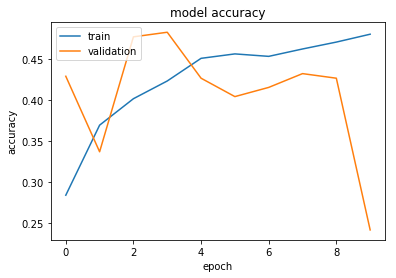

In [19]:
#Plot to determine if the model is overfitting on the training set
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Confusion Matrix and Classification Report

In [49]:
y_test = []
y_pred = []
labels = ['none', 'shirt', 'sweater', 'tee', 'outerwear', 'suit', 'tank', 'dress']
for i in labels:
    print('Processing',i)
    img_files = os.listdir('test_data/'+i)
    for imgs in img_files:
        img = load_img(('test_data/'+i+'/'+imgs), target_size=(224, 224))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        pred = model_final.predict(img)[0]
        preds_labels = list(zip(labels, pred))
#         print(preds_labels)
        preds_labels.sort(key=lambda p: p[1], reverse=True)
        y_test.append(i)
        y_pred.append(preds_labels[0][0])
        

Processing none
Processing shirt
Processing sweater
Processing tee
Processing outerwear
Processing suit
Processing tank
Processing dress


In [73]:
cf = confusion_matrix(y_test,y_pred,labels=labels)

In [74]:
cf

array([[ 0,  1, 50,  5,  5, 13,  1,  1],
       [ 0,  0,  8,  0,  1,  2,  1,  0],
       [ 0,  1,  4,  0,  0,  1,  1,  0],
       [10,  0,  2,  0,  0,  1,  0,  0],
       [ 0,  1, 21,  2,  0,  1,  0,  0],
       [ 0,  0,  6,  0,  0, 18,  0,  0],
       [ 1,  2,  2,  0,  0,  0,  0,  1],
       [ 0,  6, 10,  0,  1,  3,  1,  2]])

In [78]:
df_cf = pd.DataFrame(cf)

df_cf.index = labels
df_cf.columns = labels

df_cf

,none,shirt,sweater,tee,outerwear,suit,tank,dress
none,0,1,50,5,5,13,1,1
shirt,0,0,8,0,1,2,1,0
sweater,0,1,4,0,0,1,1,0
tee,10,0,2,0,0,1,0,0
outerwear,0,1,21,2,0,1,0,0
suit,0,0,6,0,0,18,0,0
tank,1,2,2,0,0,0,0,1
dress,0,6,10,0,1,3,1,2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


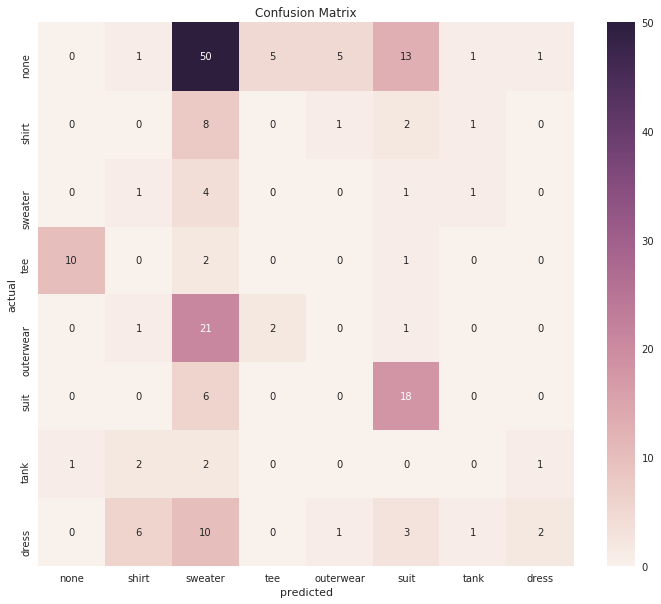

In [90]:
plt.figure(figsize=(12,10))
plt.title('Confusion Matrix')
ax = sns.heatmap(df_cf, annot=True);
ax.set(xlabel='predicted', ylabel='actual');

In [55]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

      dress       0.50      0.09      0.15        23
       none       0.00      0.00      0.00        76
  outerwear       0.00      0.00      0.00        25
      shirt       0.00      0.00      0.00        12
       suit       0.46      0.75      0.57        24
    sweater       0.04      0.57      0.07         7
       tank       0.00      0.00      0.00         6
        tee       0.00      0.00      0.00        13

avg / total       0.12      0.13      0.09       186

